In [0]:
a = []
while(1):
    a.append(1)

<h2> Elo world </h2>

<h4> In this kernel, I build a LGBM model that aggregates the new_merchant_transactions.csv and historical_transactions.csv tables to the main train table. New features are built by successive grouping oncard_id and month_lag, in order to recover some information from the time series. </h4>

<h4> 1) Problem Statement : </h4>


> Develop algorithms to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty. 


<h4> 2) Real world/Business Objectives and constraints </h4>

> Predict a loyalty score for credit cards based on historical data and merchant information.

>Some form of interpretability.


<h4> 3) Mapping to an ML problem:Data overview: </h4>

totally we have 5 csv files

> The data is formatted as follows:

> "train.csv" and "test.csv" contain card_ids and information about the card itself."train.csv" also contains the target.

>"historical_transactions.csv" and "new_merchant_transactions.csv" are designed to be joined with "train.csv", "test.csv", and "merchants.csv". 
They contain information about transactions for each card, as described above.

>"merchants" can be joined with the transaction sets to provide additional merchant-level information.

Performance metric :

>Root Mean Square Error

We'll be using the root mean squared error as our evaluation metric:

$$
RMSE(y, \hat{y}) = \sqrt{ \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2 }
$$


In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<h2> Memory usage </h2>

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<h3> 4) Reading Data </h3>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<h3> 4.1) Reading `train_data` </h3>

In [0]:
e = pd.read_excel('/content/drive/My Drive/Elo Merchant/Data Dictionary.xlsx', sheet_name='train')
e

,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


-Looks like, we have 3 categorical features `feature_1`, `feature_2` & `feature_3`.



-`first_active_month` will be helpful in extracting date features



-`target` is a label

In [0]:
%%time
train_data = reduce_mem_usage(pd.read_csv("/content/drive/My Drive/Elo Merchant/train.csv", parse_dates=['first_active_month']))
print('Number of data points : ', train_data.shape[0])
print('Number of features : ', train_data.shape[1])
print('Features : ', train_data.columns.values)
train_data.head()

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Number of data points :  201917
Number of features :  6
Features :  ['first_active_month' 'card_id' 'feature_1' 'feature_2' 'feature_3'
 'target']
CPU times: user 219 ms, sys: 106 ms, total: 325 ms
Wall time: 1.21 s


In [0]:
train_data = train_data.drop_duplicates()
print('Number of points after removing duplicates  :', train_data.shape[0])

Number of points after removing duplicates  : 201917


In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  201917 non-null  datetime64[ns]
 1   card_id             201917 non-null  object        
 2   feature_1           201917 non-null  int8          
 3   feature_2           201917 non-null  int8          
 4   feature_3           201917 non-null  int8          
 5   target              201917 non-null  float16       
dtypes: datetime64[ns](1), float16(1), int8(3), object(1)
memory usage: 4.0+ MB


In [0]:
#Visualizing Null data in Dataframe
#https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation
%%time
train_data.isnull().sum()

CPU times: user 14 ms, sys: 0 ns, total: 14 ms
Wall time: 13.4 ms


first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

There are no Null values in `train_data`.

In [0]:
train_data['feature_1'].unique()

array([5, 4, 2, 1, 3])

In [0]:
train_data['feature_2'].unique()

array([2, 1, 3])

In [0]:
train_data['feature_3'].unique()

array([1, 0])

<h4> Feature Engineering </h4>

In [0]:
#https://medium.com/@swethalakshmanan14/simple-ways-to-extract-features-from-date-variable-using-python-60c33e3b0501
train_data["month"] = train_data["first_active_month"].dt.month
train_data["year"] = train_data["first_active_month"].dt.year
train_data["diff_time"] = (train_data['first_active_month'].dt.date.max() - train_data['first_active_month'].dt.date).dt.days

<h3> 4.2) Reading `test_data` </h3>

In [0]:
%%time
test_data =pd.read_csv("/content/drive/My Drive/Elo Merchant/test.csv" , parse_dates=["first_active_month"])
print('Number of data points : ', test_data.shape[0])
print('Number of features : ', test_data.shape[1])
print('Features : ', test_data.columns.values)
test_data.head()

Number of data points :  123623
Number of features :  5
Features :  ['first_active_month' 'card_id' 'feature_1' 'feature_2' 'feature_3']
CPU times: user 141 ms, sys: 5.02 ms, total: 146 ms
Wall time: 179 ms


In [0]:
test_data = test_data.drop_duplicates()
print('Number of points after removing duplicates  :', test_data.shape[0])

Number of points after removing duplicates  : 123623


<h3> Exploratory Data Analysis </h3>

<h3> Exploratory Data Analysis - Train & Test dataset </h3>

<h4> `Target` </h4>

In [0]:
sns.countplot(train_data['target'], palette='Set3')

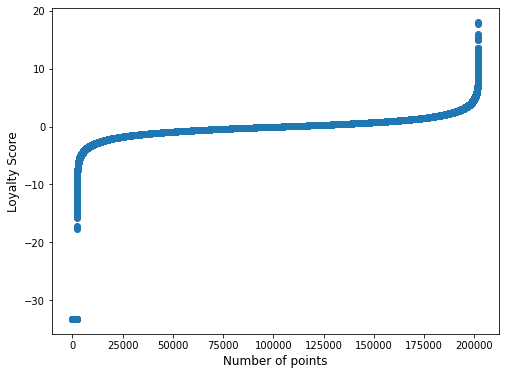

In [0]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
target_col = "target"
plt.figure(figsize=(8,6))
plt.scatter(range(train_data.shape[0]), np.sort(train_data[target_col].values))
plt.xlabel('Number of points', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

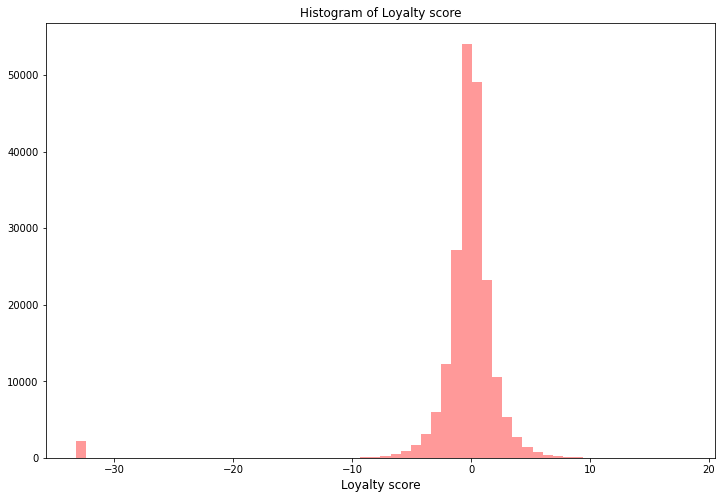

In [0]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
plt.figure(figsize=(12,8))
sns.distplot(train_data[target_col].values, bins=60, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

it is evident from the above graph, most of the loyalty scores in the range of -10 to 10.

looks like there are some potential numbers of loyalty scores in -30, may be they were outliers.

In [0]:
(train_data[target_col]<-30).sum()

2207

<h4> Percentiles </h4>

Since, we have few outliers when the data is posed on Histogram.

Let us use percentiles to trace its exact origin.

In [0]:
#Calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =train_data[target_col].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -33.21928095
10 percentile value is -2.04231327
20 percentile value is -1.14604394
30 percentile value is -0.66396308
40 percentile value is -0.31220831
50 percentile value is -0.02343689
60 percentile value is 0.23620054
70 percentile value is 0.56450565
80 percentile value is 1.01425572
90 percentile value is 1.83029589
100 percentile value is  17.9650684


Value at zeroth percentile looks strange. 
Let us check its origin deeply

Looks, like 100th percentile value looks slight deviation from the rest of the points.

In [0]:
#Looking further from the 1st percecntile
for i in range(1,11):
    var =train_data[target_col].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
#print ("10 percentile value is ",var[-1])

1 percentile value is -33.21928095
2 percentile value is -5.01608376
3 percentile value is -4.06331826
4 percentile value is -3.49376358
5 percentile value is -3.10796501
6 percentile value is -2.80808288
7 percentile value is -2.56256564
8 percentile value is -2.36228882
9 percentile value is -2.19336416
10 percentile value is -2.04231327


clearly looks like an outlier from the above percentiles.

Therefore, total number of data points present was 201917, out of which 2207 were found out to be outliers.

In [0]:
#removing further outliers based on the 1st percentile value
train_df=train_data[(train_data[target_col]>-5) & (train_data[target_col]<18)]
train_df.shape[0]

197848

<h4> `first_active_month` </h4>

<h5> Train data : </h5>

In [0]:
#start date of a training dataset
train_df["first_active_month"].min()

Timestamp('2011-11-01 00:00:00')

In [0]:
#End date of a training dataset
train_df["first_active_month"].max()

Timestamp('2018-02-01 00:00:00')

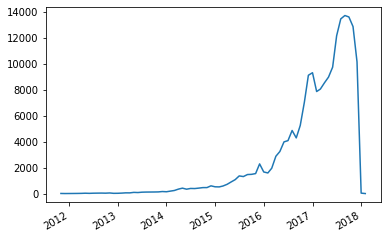

In [0]:
train_df["first_active_month"].value_counts().plot()

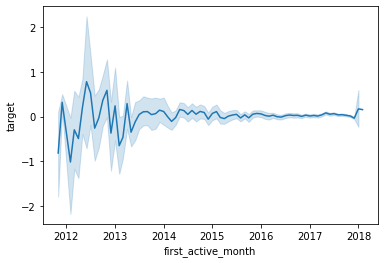

In [0]:
# first_active_month vs loyalty score
sns.lineplot(x='first_active_month', y='target', data=train_df)
plt.show()

From the above graph, it is evident that Loyalty scores improve gradually over a period of time. 

And takes a steady steep, post 2014.

<h5> Test data: </h5>

In [0]:
#start date of a test dataset
test_data["first_active_month"].min()

Timestamp('2011-11-01 00:00:00')

In [0]:
#End date of a test dataset
test_data["first_active_month"].max()

Timestamp('2018-01-01 00:00:00')

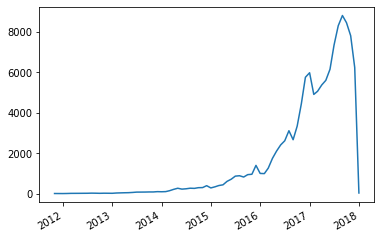

In [0]:
test_data["first_active_month"].value_counts().plot()

Both the distributions of "first_active_month"  for train and test data looks similar.

<h4>  `feature_1`, `feature_2` & `feature_3` </h4>

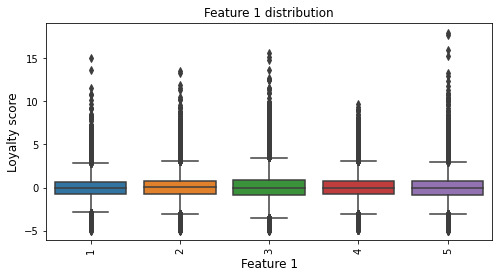

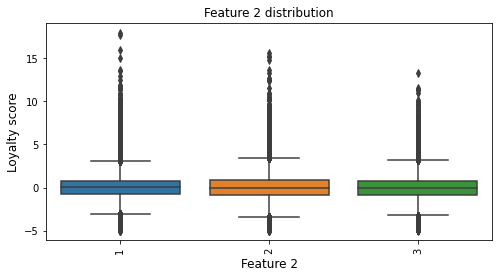

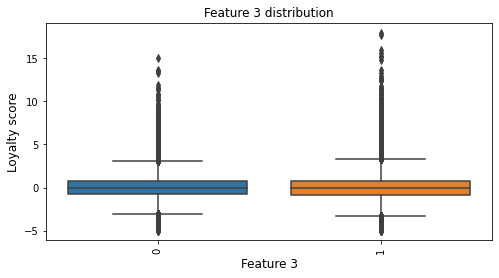

In [0]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
# feature 1
plt.figure(figsize=(8,4))
sns.boxplot(x="feature_1", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
plt.show()

# feature 2
plt.figure(figsize=(8,4))
sns.boxplot(x="feature_2", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
plt.show()

# feature 3
plt.figure(figsize=(8,4))
sns.boxplot(x="feature_3", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
plt.show()

Even the distributions of 3 features were looks similar.

Therefore, it is evident that from the above plots the dataset has some outliers. If we remove the outliers the dataset looks imbalance and to overcome this we have to use oversampling and then pose the problem as classification teachnique to solve this.

Now, without considering the outliers the dataset looks like a regression model and if we apply any one of the baseline models and selects the best model.

Our approach on this problem is:

1) Apply linear regression baseline models to achieve less RMSE value

2) Remove outliers and apply oversampling on top of it and slove it by a classification technique.

Till now we have visualise Train and Test csv files,

Now, let us visualise the rest of the features from the other csv files.

<h3> 4.3) Reading `historical transactions` </h3>

In [0]:
e = pd.read_excel('/content/drive/My Drive/Elo Merchant/Data Dictionary.xlsx', sheet_name='history')
e

,historical_transactions.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


`category_1`, `category_2`, `category_3` are categotical features.


Since, few of the line itmes in category features have nan values..Now, let us convert this in to numerical features and look for any similarities between the features. If the features looks similar then we are dropping this off from the dataset and if the features are different we continue to add this in the dataset.

In [0]:
%%time
hist = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/Elo Merchant/historical_transactions.csv'))
print('Number of data points : ', hist.shape[0])
print('Number of features : ', hist.shape[1])
print('Features : ', hist.columns.values)
hist.head()

Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Number of data points :  29112361
Number of features :  14
Features :  ['authorized_flag' 'card_id' 'city_id' 'category_1' 'installments'
 'category_3' 'merchant_category_id' 'merchant_id' 'month_lag'
 'purchase_amount' 'purchase_date' 'category_2' 'state_id' 'subsector_id']
CPU times: user 49.4 s, sys: 17.9 s, total: 1min 7s
Wall time: 1min 21s


In [0]:
hist_1 = pd.merge(left=train_data, right=hist, on="card_id", how="left")
hist_1.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,Y,69,N,0,A,195,M_ID_cc72dac895,-3,-0.506033,2017-11-25 16:37:11,1.0,9,34
1,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,Y,69,N,0,A,278,M_ID_c9c0f1cb3f,-7,-0.722114,2017-07-16 12:21:00,1.0,9,37
2,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,Y,69,N,0,A,683,M_ID_36f9e41993,-6,-0.726171,2017-08-10 21:01:16,1.0,9,34
3,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,Y,69,N,0,A,309,M_ID_b790230ee9,-2,-0.610167,2017-12-15 12:06:58,1.0,9,21
4,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,Y,69,N,0,A,278,M_ID_ab67f6c982,-7,-0.307232,2017-07-08 15:13:18,1.0,9,37


In [0]:
hist_1=hist_1.drop_duplicates(subset=['card_id'], keep="first")

In [0]:
%%time
hist_1.isnull().sum()

CPU times: user 150 ms, sys: 0 ns, total: 150 ms
Wall time: 149 ms


first_active_month      0
card_id                 0
feature_1               0
feature_2               0
feature_3               0
target                  0
authorized_flag         0
city_id                 0
category_1              0
installments            0
category_3              0
merchant_category_id    0
merchant_id             0
month_lag               0
purchase_amount         0
purchase_date           0
category_2              0
state_id                0
subsector_id            0
dtype: int64

In [0]:
hist_1['category_2'] = hist_1['category_2'].replace(np.nan, 1.0)
hist_1['category_3'] = hist_1['category_3'].replace(np.nan, 'A')
hist_1['merchant_id'] = hist_1['merchant_id'].replace(np.nan, 'M_ID_00a6ca8a8a')

In [0]:
#Installments
hist['installments'].value_counts()

 0      15336465
 1      11621828
 2        666348
 3        538099
 4        179497
-1        170952
 6        132609
 10       118818
 5        116046
 12        55056
 8         20471
 7         10902
 9          5771
 11          830
 999         188
Name: installments, dtype: int64

Here we have a hiccup, installments starts from the range of 0-11 months.

But here we have -1 and 999 looks strange.

This might be a false transactions.

In [0]:
# let's convert the authorized_flag to a binary value.
hist['authorized_flag'] = hist['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

In [0]:
hist.groupby(['installments'])['authorized_flag'].mean()

installments
-1      0.888612
 0      0.928268
 1      0.907247
 2      0.884101
 3      0.862425
 4      0.820030
 5      0.809472
 6      0.779857
 7      0.693451
 8      0.692541
 9      0.663836
 10     0.702065
 11     0.660241
 12     0.653753
 999    0.031915
Name: authorized_flag, dtype: float64

In [0]:
#removing further outliers based on the 1st percentile value
hist_f=hist[(hist['installments']>0) & (hist['installments']<12)]
hist_f.shape[0]

13411219

<h3> EDA on "Historical_transactions".csv </h3>

In [0]:
hist_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13383837 entries, 400 to 29112357
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       int64  
 1   card_id               object 
 2   city_id               int64  
 3   category_1            int64  
 4   installments          int64  
 5   category_3            object 
 6   merchant_category_id  int64  
 7   merchant_id           object 
 8   month_lag             int64  
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            float64
 12  state_id              int64  
 13  subsector_id          int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 1.5+ GB


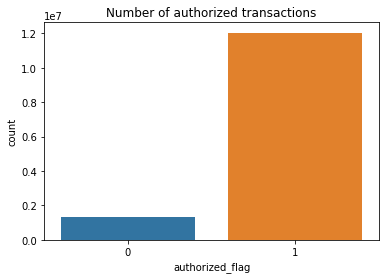

In [0]:
#Authorised flag
sns.countplot(x='authorized_flag', data=hist_f)
plt.title('Number of authorized transactions')
plt.show()

seems like, most of the transactions were Authorized.

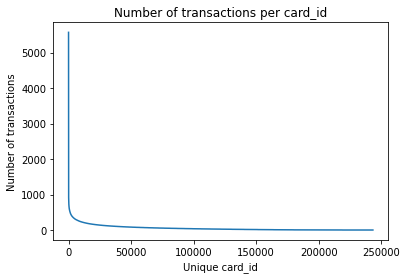

In [0]:
# card_id
plt.plot(hist_f['card_id'].value_counts().values)
plt.xlabel('Unique card_id')
plt.ylabel('Number of transactions')
plt.title('Number of transactions per card_id')
plt.show()

seems like very few card_id has the most number of transactions

In [0]:
#hist['installments'] = hist['installments'].astype('category')

In [0]:
hist_f['purchase_date'] = pd.to_datetime(hist_f['purchase_date'])

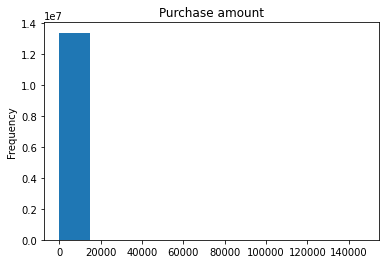

In [0]:
#Purchase_amount
plt.title('Purchase amount');
hist_f['purchase_amount'].plot(kind='hist');

Looks like Purchase amount is Normalised.

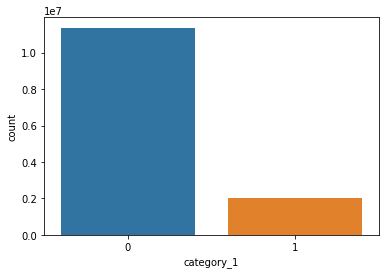

In [0]:
#from matplotlib.ticker import FormatStrFormatter
# category_1
sns.countplot(x='category_1', data=hist_f)
plt.show()


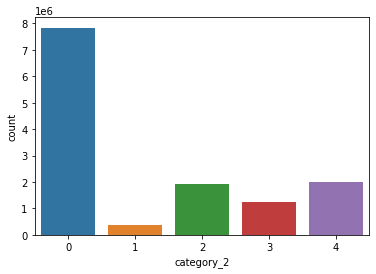

In [0]:
# category_2
from matplotlib.ticker import FormatStrFormatter
sns.countplot(x='category_2', data=hist_f)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

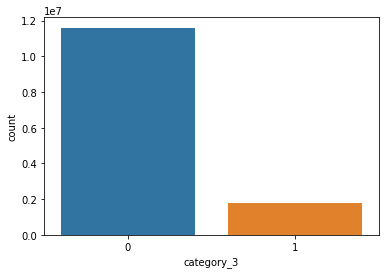

In [0]:
# category_3
sns.countplot(x='category_3', data=hist_f)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

Initially, we have 3 categories before removing the outliers from 'installments'.

we are left with 2 categories post removing the outliers from 'installments'.

All the Categories are quite different.

Other categorical data are:

In [0]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print(f"There are {hist_f[col].nunique()} unique values in {col}.")

There are 308 unique values in city_id.
There are 323 unique values in merchant_category_id.
There are 281886 unique values in merchant_id.
There are 25 unique values in state_id.
There are 41 unique values in subsector_id.


<h3> 4.4)Reading `new_merchant_transactions` </h3>

In [0]:
e = pd.read_excel('/content/drive/My Drive/Elo Merchant/Data Dictionary.xlsx', sheet_name='new_merchant_period')
e

,new_merchant_period.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


`category_1`, `category_2`, `category_3` are categotical features.

Even feature `installments` looks like a categorical one, all the installments range between 0-11 months.

In [0]:
%%time
new_merch =reduce_mem_usage(pd.read_csv("/content/drive/My Drive/Elo Merchant/new_merchant_transactions.csv"))
print('Number of data points : ', new_merch.shape[0])
print('Number of features : ', new_merch.shape[1])
print('Features : ', new_merch.columns.values)

new_merch.head(3)

Mem. usage decreased to 114.20 Mb (45.5% reduction)
Number of data points :  1963031
Number of features :  14
Features :  ['authorized_flag' 'card_id' 'city_id' 'category_1' 'installments'
 'category_3' 'merchant_category_id' 'merchant_id' 'month_lag'
 'purchase_amount' 'purchase_date' 'category_2' 'state_id' 'subsector_id']
CPU times: user 3.69 s, sys: 364 ms, total: 4.05 s
Wall time: 5.59 s


In [0]:
hist_2 = pd.merge(left=hist_1, right=new_merch, on="card_id", how="left")
hist_2.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,authorized_flag_x,city_id_x,category_1_x,installments_x,category_3_x,merchant_category_id_x,merchant_id_x,month_lag_x,purchase_amount_x,purchase_date_x,category_2_x,state_id_x,subsector_id_x,authorized_flag_y,city_id_y,category_1_y,installments_y,category_3_y,merchant_category_id_y,merchant_id_y,month_lag_y,purchase_amount_y,purchase_date_y,category_2_y,state_id_y,subsector_id_y
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,Y,69,N,0,A,195,M_ID_cc72dac895,-3,-0.506033,2017-11-25 16:37:11,1.0,9,34,Y,19.0,N,0.0,A,80.0,M_ID_98b342c0e3,1.0,-0.491455,2018-03-30 10:30:32,1.0,9.0,37.0
1,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,Y,69,N,0,A,195,M_ID_cc72dac895,-3,-0.506033,2017-11-25 16:37:11,1.0,9,34,Y,69.0,N,0.0,A,80.0,M_ID_28a21ea733,2.0,-0.666504,2018-04-06 10:55:08,1.0,9.0,37.0
2,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,Y,69,N,0,A,195,M_ID_cc72dac895,-3,-0.506033,2017-11-25 16:37:11,1.0,9,34,Y,19.0,N,0.0,A,278.0,M_ID_20dce166b9,1.0,-0.635254,2018-03-29 15:38:10,1.0,9.0,37.0
3,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,Y,69,N,0,A,195,M_ID_cc72dac895,-3,-0.506033,2017-11-25 16:37:11,1.0,9,34,Y,69.0,N,0.0,A,842.0,M_ID_f7796994d1,2.0,-0.581055,2018-04-09 13:56:50,1.0,9.0,37.0
4,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,Y,69,N,0,A,195,M_ID_cc72dac895,-3,-0.506033,2017-11-25 16:37:11,1.0,9,34,Y,276.0,N,0.0,A,783.0,M_ID_0703c10cc0,1.0,-0.296143,2018-03-12 16:49:03,1.0,9.0,19.0


In [0]:
hist_2=hist_2.drop_duplicates(subset=['card_id'], keep="first")

Merchant_id can never be an empty or Nan.. This should have an ID, without an ID the transactions might look meaningless. So, I have removed the transactions beloging to Nan in Merchant_id.

Merchant_id and card_id are the unique fields that shouldn't be empty.

In [0]:
hist_2['category_2_y'] = hist_2['category_2_y'].replace(np.nan, 1.0)
hist_2['category_3_y'] = hist_2['category_3_y'].replace(np.nan, 'A')
hist_2['merchant_id_y'] = hist_2['merchant_id_y'].replace(np.nan, 'M_ID_00a6ca8a8a')
hist_2['authorized_flag_y'] = hist_2['authorized_flag_y'].replace(np.nan, 'Y')

In [0]:
#https://stackoverflow.com/questions/57577188/replace-nan-values-by-user-defined-values-in-categorical-variables
#replacing category_2 which has Null values using user defined values

def nan_impute(df, col):
  p = df[col].value_counts(normalize=True)  # Series of probabilities
  m = df[col].isnull()

  np.random.seed(42)
  rand_fill = np.random.choice(p.index, size=m.sum(), p=p)  

  df.loc[m, col] = rand_fill
  

In [0]:
nan_impute(hist_2, 'merch_price')

In [0]:
#Installments
new_merch['installments'].value_counts()

 0      909084
 1      825304
 2       54729
-1       53740
 3       44750
 4       14815
 6       10389
 5        9296
 10       8899
 12       2850
 8        1555
 7         863
 9         478
 11         61
 999         2
Name: installments, dtype: int64

Here we have a hiccup, installments starts from the range of 0-11 months.

But here we have -1 and 999 looks strange.

This might be a false transactions.

In [0]:
# let's convert the authorized_flag to a binary value.
new_merch['authorized_flag'] = new_merch['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

In [0]:
#removing further outliers based on the 1st percentile value
new_merch_f=new_merch[(new_merch['installments']>0) & (new_merch['installments']<12)]
new_merch_f.shape[0]

971139

EDA for New_merchants.csv

In [0]:
new_merch_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 971128 entries, 0 to 1963028
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   authorized_flag       971128 non-null  int64  
 1   card_id               971128 non-null  object 
 2   city_id               971128 non-null  int64  
 3   category_1            971128 non-null  int64  
 4   installments          971128 non-null  int64  
 5   category_3            971128 non-null  object 
 6   merchant_category_id  971128 non-null  int64  
 7   merchant_id           971128 non-null  object 
 8   month_lag             971128 non-null  int64  
 9   purchase_amount       971128 non-null  float64
 10  purchase_date         971128 non-null  object 
 11  category_2            971128 non-null  float64
 12  state_id              971128 non-null  int64  
 13  subsector_id          971128 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 11

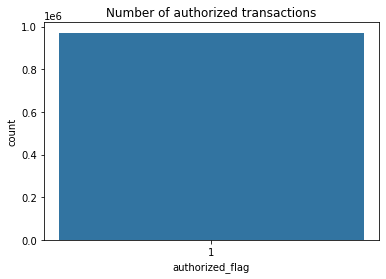

In [0]:
#Authorised flag
sns.countplot(x='authorized_flag', data=new_merch_f)
plt.title('Number of authorized transactions')
plt.show()

in this, all the transactions were authorised.

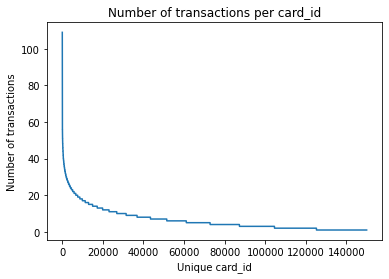

In [0]:
# card_id
plt.plot(new_merch_f['card_id'].value_counts().values)
plt.xlabel('Unique card_id')
plt.ylabel('Number of transactions')
plt.title('Number of transactions per card_id')
plt.show()

very few customers made multiple transactions, where as majority of the transactions were below less than 20 by the customers.

In [0]:
#new_merch['installments'] = new_merch['installments'].astype('category')

In [0]:
new_merch_f['purchase_date'] = pd.to_datetime(new_merch_f['purchase_date'])

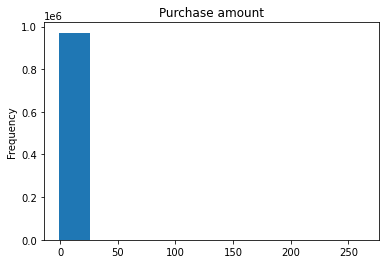

In [0]:
#Purchase_amount
plt.title('Purchase amount');
new_merch_f['purchase_amount'].plot(kind='hist');

Looks like Purchase amount is Normalised

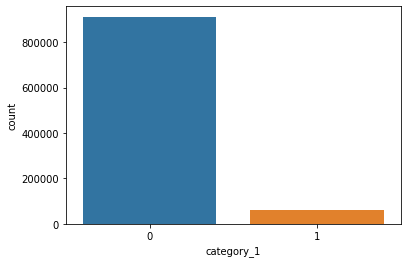

In [0]:
#from matplotlib.ticker import FormatStrFormatter
# category_1
sns.countplot(x='category_1', data=new_merch_f)
plt.show()


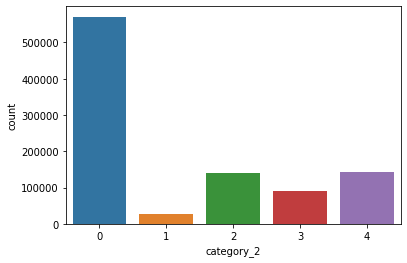

In [0]:
# category_2
from matplotlib.ticker import FormatStrFormatter
sns.countplot(x='category_2', data=new_merch_f)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

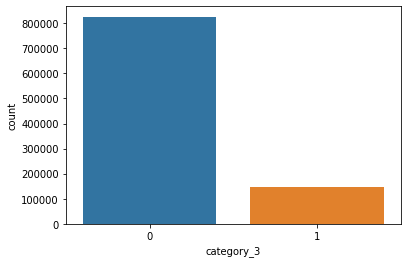

In [0]:
# category_3
sns.countplot(x='category_3', data=new_merch_f)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

All the 3 categories are quite different

Other categorical data are:

In [0]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print(f"There are {new_merch_f[col].nunique()} unique values in {col}.")

There are 308 unique values in city_id.
There are 302 unique values in merchant_category_id.
There are 165778 unique values in merchant_id.
There are 25 unique values in state_id.
There are 41 unique values in subsector_id.


In [0]:
hist_2.to_csv('hist_2.csv')

<h3> 4.5) Reading `merchants` </h3>

In [0]:
%%time
merch =pd.read_csv("/content/drive/My Drive/Elo Merchant/merchants.csv")
print('Number of data points : ', merch.shape[0])
print('Number of features : ', merch.shape[1])
print('Features : ', merch.columns.values)
merch.head()

Number of data points :  334696
Number of features :  22
Features :  ['merchant_id' 'merchant_group_id' 'merchant_category_id' 'subsector_id'
 'numerical_1' 'numerical_2' 'category_1' 'most_recent_sales_range'
 'most_recent_purchases_range' 'avg_sales_lag3' 'avg_purchases_lag3'
 'active_months_lag3' 'avg_sales_lag6' 'avg_purchases_lag6'
 'active_months_lag6' 'avg_sales_lag12' 'avg_purchases_lag12'
 'active_months_lag12' 'category_4' 'city_id' 'state_id' 'category_2']
CPU times: user 898 ms, sys: 73.4 ms, total: 971 ms
Wall time: 3.49 s


CPU times: user 188 ms, sys: 4.84 ms, total: 193 ms
Wall time: 192 ms


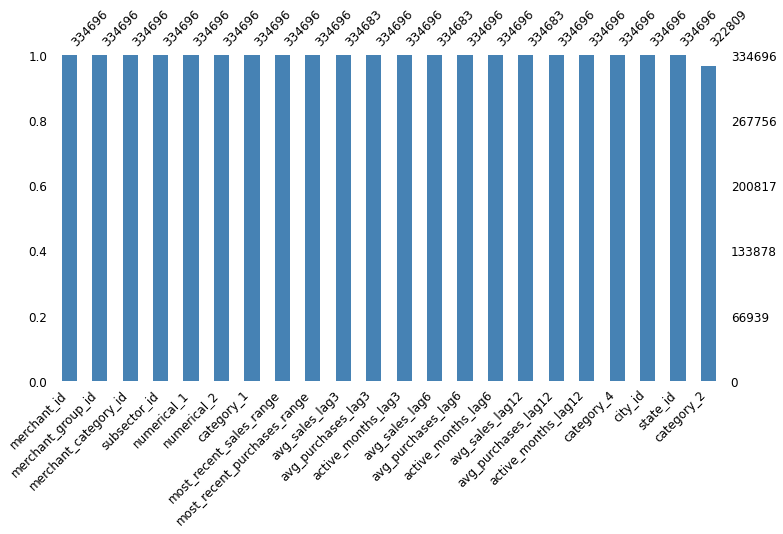

In [0]:
%%time
#Visualizing Null data in Dataframe
#https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation
import missingno as msno
import matplotlib.pyplot as plt
msno.bar(merch, figsize=(12, 6), fontsize=12, color='steelblue')

`avg_sales_lag12`,`avg_sales_lag6` , `avg_sales_lag3` & `category_2` has Null values.

Once we have uploaded all the csv files, 

Let us look at the features of each file and check its distributions, variance or any outliers present using EDA.

<h2>EDA on Merchants.csv </h2>

In [0]:
merch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int64
merchant_category_id           334696 non-null int64
subsector_id                   334696 non-null int64
numerical_1                    334696 non-null float64
numerical_2                    334696 non-null float64
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float64
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int64
avg_sales_lag6                 334683 non-null float64
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int64
avg_sales_lag12                334683 non-null float64
avg_purchases_lag12    

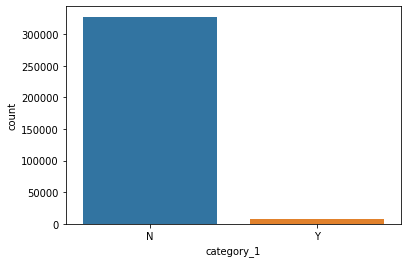

In [0]:
#from matplotlib.ticker import FormatStrFormatter
# category_1
sns.countplot(x='category_1', data=merch)
plt.show()

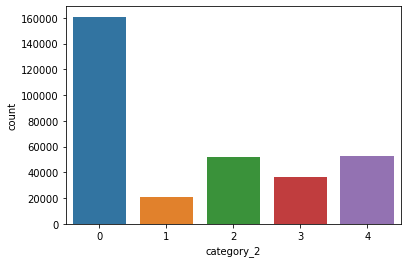

In [0]:
# category_2
from matplotlib.ticker import FormatStrFormatter
sns.countplot(x='category_2', data=merch)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

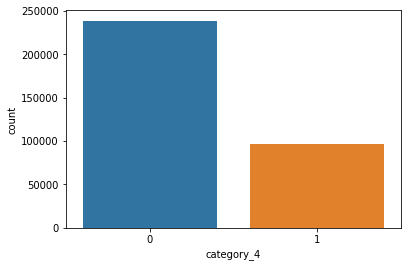

In [0]:
# category_3
sns.countplot(x='category_4', data=merch)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

All the 3 categories looks quite different

<h3> Numerical data </h3>

<h4> Numerical_1 </h4>

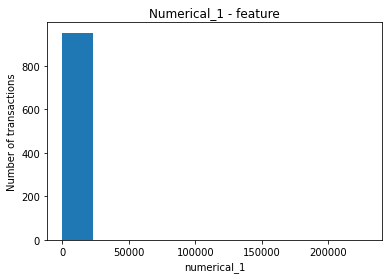

In [0]:
# numerical_1
plt.hist(merch['numerical_1'].value_counts().values)
plt.xlabel('numerical_1')
plt.ylabel('Number of transactions')
plt.title('Numerical_1 - feature')
plt.show()

In [0]:
np.percentile(merch['numerical_1'], 95)

0.09125291

95% of values are less than 0.1

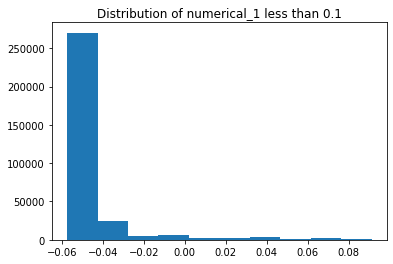

In [0]:
#https://www.kaggle.com/artgor/elo-eda-and-models
plt.hist(merch.loc[merch['numerical_1'] < 0.1, 'numerical_1']);
plt.title('Distribution of numerical_1 less than 0.1');

<h4> Numerical_2 </h4>

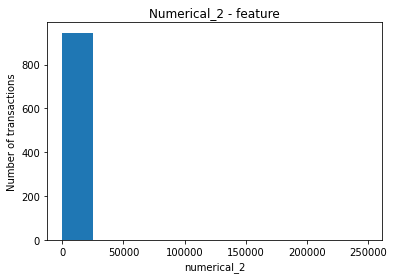

In [0]:
# numerical_2
plt.hist(merch['numerical_2'].value_counts().values)
plt.xlabel('numerical_2')
plt.ylabel('Number of transactions')
plt.title('Numerical_2 - feature')
plt.show()

above plot doesn't help in providing any insight on the data.

In [0]:
np.percentile(merch['numerical_2'], 95)

0.08133801

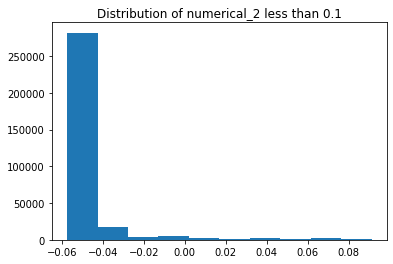

In [0]:
#https://www.kaggle.com/artgor/elo-eda-and-models
plt.hist(merch.loc[merch['numerical_2'] < 0.1, 'numerical_2']);
plt.title('Distribution of numerical_2 less than 0.1');

Both the distributions of `numerical_1` & `numerical_2` looks similar

<h4> most_recent_sales_range </h4>

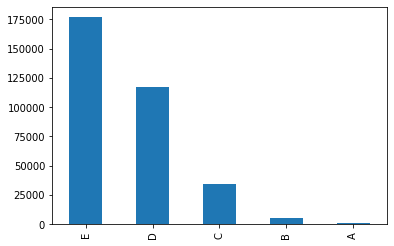

In [0]:
#most_recent_sales_range
merch['most_recent_sales_range'].value_counts().plot('bar');

<h4> most_recent_purchases_range </h4>

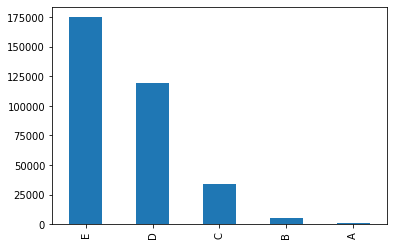

In [0]:
#most_recent_purchases_range
merch['most_recent_purchases_range'].value_counts().plot('bar');

Both the distributions of `most_recent_purchases_range`  & `most_recent_purchases_sales` are similar

<h3> avg_sales_lag </h3>

<h4> avg_sales_lag3 </h4>

In [0]:
for col in ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']:
    print(f'Max value of {col} is {merch[col].max()}')
    print(f'Min value of {col} is {merch[col].min()}')

Max value of avg_sales_lag3 is 851844.64
Min value of avg_sales_lag3 is -82.13
Max value of avg_sales_lag6 is 1513959.0
Min value of avg_sales_lag6 is -82.13
Max value of avg_sales_lag12 is 2567408.0
Min value of avg_sales_lag12 is -82.13


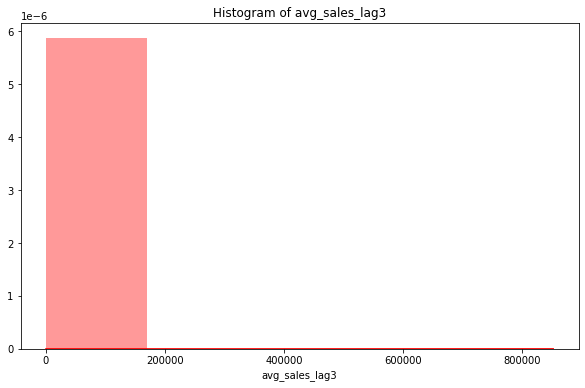

In [0]:
plt.figure(figsize=(10,6))
sns.distplot(merch['avg_sales_lag3'].values, bins=5, color="red")
plt.title("Histogram of avg_sales_lag3")
plt.xlabel('avg_sales_lag3', fontsize=10)
plt.show()

<h4> avg_sales_lag6 </h4>

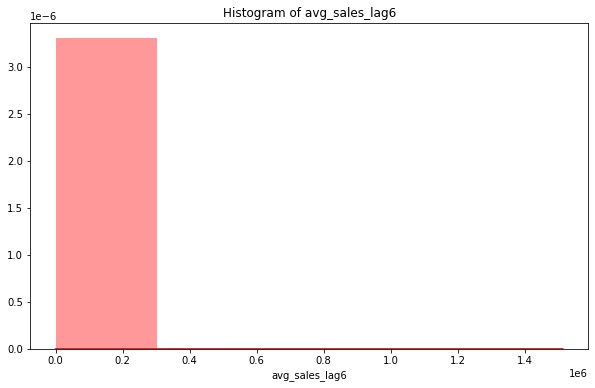

In [0]:
plt.figure(figsize=(10,6))
sns.distplot(merch['avg_sales_lag6'].values, bins=5, color="red")
plt.title("Histogram of avg_sales_lag6")
plt.xlabel('avg_sales_lag6', fontsize=10)
plt.show()

<h4> avg_sales_lag12 </h4>

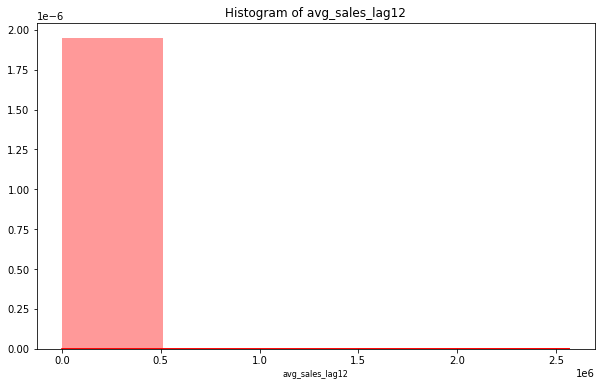

In [0]:
plt.figure(figsize=(10,6))
sns.distplot(merch['avg_sales_lag12'].values, bins=5, color="red")
plt.title("Histogram of avg_sales_lag12")
plt.xlabel('avg_sales_lag12', fontsize=8)
plt.show()

data in the columns of `avg_sales_lag12`, `avg_sales_lag3` & `avg_sales_lag6` are Normalised.

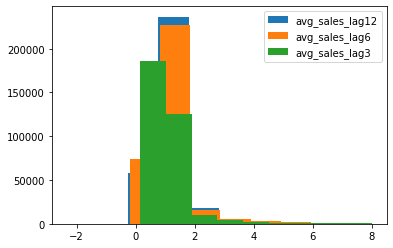

In [0]:
#https://www.kaggle.com/artgor/elo-eda-and-models
plt.hist(merch.loc[(merch['avg_sales_lag12'] < 8) & (merch['avg_sales_lag12'] > -10), 'avg_sales_lag12'], label='avg_sales_lag12');
plt.hist(merch.loc[(merch['avg_sales_lag6'] < 8) & (merch['avg_sales_lag6'] > -10), 'avg_sales_lag6'], label='avg_sales_lag6');
plt.hist(merch.loc[(merch['avg_sales_lag3'] < 8) & (merch['avg_sales_lag3'] > -10), 'avg_sales_lag3'], label='avg_sales_lag3');
plt.legend();

More or less, all the distributions looks similar(each feature is overlapping with each other).

<h3> avg_purchases_lag </h3>

<h4> `avg_purchases_lag3`, `avg_purchases_lag6` & `avg_purchases_lag12` </h4>

In [0]:
for col in ['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']:
    print(f'Max value of {col} is {merch[col].max()}')
    print(f'Min value of {col} is {merch[col].min()}')

Max value of avg_purchases_lag3 is inf
Min value of avg_purchases_lag3 is 0.33349533
Max value of avg_purchases_lag6 is inf
Min value of avg_purchases_lag6 is 0.16704466
Max value of avg_purchases_lag12 is inf
Min value of avg_purchases_lag12 is 0.09832954


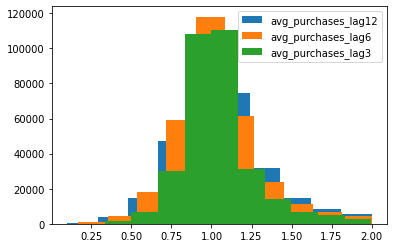

In [0]:
plt.hist(merch.loc[(merch['avg_purchases_lag12'] < 2), 'avg_purchases_lag12'], label='avg_purchases_lag12');
plt.hist(merch.loc[(merch['avg_purchases_lag6'] < 2), 'avg_purchases_lag6'], label='avg_purchases_lag6');
plt.hist(merch.loc[(merch['avg_purchases_lag3'] < 2), 'avg_purchases_lag3'], label='avg_purchases_lag3');
plt.legend();

Even all the distributions looks similar.

Therefore, all the distributions of features looks similar and we can ignore the merchant file for not further adding to the existing train and test files.
By adding Merchant file in to the train and test dataset will be not be effective in deciding the predicted value.

Why we are not considering the features ?

Each independent feature should be different to each other to predict an output and also it is very important in playing a significant role in `feature selection`.